In [1]:
import nltk
import pandas as pd
import random
import numpy as np
import string
import math

from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize

from numpy import array
from collections import Counter
from scipy.sparse import csr_matrix

from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel
from gensim import corpora, models, utils
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim.models import LsiModel
from gensim.corpora import Dictionary

import re

In [2]:
# Use spacy lib
# On https://spacy.io/

import spacy
nlp = spacy.load('fr')

In [3]:
##############
# Parameters #
##############

min_gram = 1
max_gram = 3

# To create ours partitions, we must first know the years which will be the limits
limit_years = [2007, 2010, 2013, 2016]

# Ignore words that appear at a frequency less than max_frequ in the corpus
max_frequ = 0.8

# Ignore words appearing less than min_appear in the whole corpus
min_appear = 5

# Range fo cluster number you want to test
cluster_ranges = range(2, 30) #range(2, 100) # Warning, long to compute (but nice)

# Number of trial you want to do for each test
nb_trial_by_test = 3

# Number of cluster you finally choose
nb_cluster = 20

# Max iteration for each kmeans (default: 300)
max_iter = 300

In [4]:
# Datas preprocessing methods.

# Lemmatisation without poncutations

stemmer = nltk.stem.snowball.FrenchStemmer()
fstw = stopwords.words('french')

# French Stop Words, extraits depuis le fichier stopwords-fr.txt + stopwords french de nltk
sourceFST = [x.replace('\n', '') for x in open('stopwords-fr.txt', mode="r", encoding="utf-8").readlines()]+fstw
sourceFST += [x.replace('\n', '') for x in open('perso_words-fr.txt', mode="r", encoding="utf-8").readlines()]

# Based on ration of french and english stopwords
def isEnglish(article):
    total_fsw = len([x for x in article.split() if x in sourceFST])
    total_esw = len([x for x in article.split() if x in stopwords.words('english')])
    ratio = 100
    if total_fsw != 0:
        ratio = total_esw/total_fsw
    return ratio > 1 and total_esw > 3

def lemmatize(article):
    arti_lower = article.lower()
    arti_2words = re.sub(" [0-z][0-z] ", " ", arti_lower) # word of length < 2
    arti_e = re.sub("(é|è|ê)", "e", arti_2words)
    arti_o = re.sub("à", "a", arti_e)
    arti_i = re.sub("ô", "o", arti_o)
    artiregex = re.sub("î", "i", arti_i)
    output = []
    outPonc = artiregex.translate(artiregex.maketrans("","", string.punctuation))
    outLem = nlp(outPonc)
    for token in outLem:
        if token.lemma_ not in sourceFST and [x for x in token.lemma_ if x not in "0123456789"] != []:
            output.append(token.lemma_)
    res = ' '.join(output)
    return res

In [5]:
# Data Reading
data = pd.read_csv('export_articles_EGC_2004_2018.csv', sep='\t', header=0)

In [6]:
# Let's process our corpus, and determine a limit to split it in partitions

# usable[] correspond to our corpus processed
# limits[] let us know when to delimit partitions
limits = []
usable = []

prev_year = data['year'][0]
numArti = 0
for i in range(0, len(data['abstract']), 1):
    #if not null, empty, or whatever (so if there is a abstract):
    if not isinstance(data['abstract'][i], float) and not isEnglish(data['abstract'][i]):
        text = data['abstract'][i]
        if not isinstance(data['title'][i], float):
            text += " "+data['title'][i]

        numArti+=1
        usable.append(re.sub(" [0-z][0-z] ", " ", stemmer.stem(lemmatize(text))))
        year = data['year'][i]
        if year != prev_year:
            prev_year = year
            if year in limit_years:
                limits.append(numArti)
limits.append(numArti)



In [7]:
# Post-process word removal
post_words = [x.replace('\n', '') for x in open('post_process_words-fr.txt', mode="r", encoding="utf-8").readlines()]

for i in range(0, len(usable)):
    arti = usable[i].split()
    res = []
    for word in arti:
        if word not in post_words:
            res.append(word)
    usable[i] = ' '.join(res)

In [8]:
# Display pre-processed datas

vectorizer = TfidfVectorizer(stop_words=sourceFST, use_idf=True, ngram_range=(min_gram, max_gram), max_df=max_frequ, min_df=min_appear)
tfidf = vectorizer.fit_transform(usable)

print("nombre d'articles =", len(usable))
print("nombre de mots =", len(tfidf.toarray()[0]))
print("limits =", limits)

usable[0]

nombre d'articles = 991
nombre de mots = 2179
limits = [114, 301, 468, 694, 991]


'plateforme objectif permettre citoyen euxmemer tweet politique devenement specifiqu francepour lelection presidentiell ideo2017 analyser quasitemps reel message candidat fournir principal caracteristiqueslusage lexiqu politique comparaison candidat ideo2017 plateforme citoyen dediee lanalyse tweet evenement polit'

In [9]:
# Creation of partitions_tfidf[], which give us the TFIDF of each cluster of each partition
# partitions_tfidf[num_partition][num_doc][num_word]
# Beware, num_doc can't be equals to 1091 (max). You have partitions, so every doc aren't in every partitions
# num_word can be found via vectorizer.get_feature_name()
partitions_tfidf = []
beg = 0
for l in limits:
    last = l
    partitions_tfidf.append([list(x) for x in list(tfidf.toarray())[beg:last]])
    beg = l

In [10]:
vectorizer.get_feature_names()

['acce',
 'accessible',
 'achat',
 'acquisition',
 'acquérir',
 'acteur',
 'actif',
 'action',
 'activite',
 'actuel',
 'actuellement',
 'adapt',
 'adaptatif',
 'adaptation',
 'adapte',
 'adaptee',
 'adapter',
 'adequat',
 'adn',
 'adopter',
 'afc',
 'affiner',
 'agent',
 'agregation',
 'aid',
 'aider',
 'ainsiqu',
 'ajoutee',
 'ajouter',
 'ala',
 'aleatoir',
 'algebriqu',
 'algorithme',
 'algorithme dapprentissage',
 'algorithme dextraction',
 'algorithme efficace',
 'algorithme fouiller',
 'algorithme incremental',
 'algorithmique',
 'alignement',
 'alternatif',
 'amelior',
 'amelioration',
 'ameliore',
 'amelioree',
 'ameliorer',
 'ameliorer qualite',
 'amene',
 'amont',
 'analys',
 'analyse',
 'analyser',
 'analyser factoriel',
 'analyser semantiqu',
 'analytique',
 'anne',
 'annees',
 'annot',
 'annotation',
 'annotation semantiqu',
 'annoter',
 'anormal',
 'anr',
 'apartir',
 'apparer',
 'appartenir',
 'appel',
 'appele',
 'appelee',
 'appeler',
 'applicable',
 'applicatif',
 'ap

# KMeans & Silhouette Score

In [11]:
# Applying KMeans on tfidf
# the labels_ give assignment of doc to the cluster number 


In [12]:
# SOURCE :
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


# Silhouette analysis can be used to study the separation distance between the resulting clusters.
# The silhouette plot displays a measure of how close each point in one cluster is to points in 
# the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.
# This measure has a range of [-1, 1].

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

For n_cluster = 5 The average silhouette_score is : 0.0103085606585095
For n_cluster = 6 The average silhouette_score is : 0.011646226563427627
For n_cluster = 7 The average silhouette_score is : 0.012406467290142399
For n_cluster = 8 The average silhouette_score is : 0.013419408582465394
For n_cluster = 9 The average silhouette_score is : 0.013548739976517647
For n_cluster = 10 The average silhouette_score is : 0.01346658192042833
For n_cluster = 11 The average silhouette_score is : 0.014825218290965565
For n_cluster = 12 The average silhouette_score is : 0.015015671428912518
For n_cluster = 13 The average silhouette_score is : 0.015240535882135324
For n_cluster = 14 The average silhouette_score is : 0.014925032133995004
For n_cluster = 15 The average silhouette_score is : 0.012063534625476626
For n_cluster = 16 The average silhouette_score is : 0.01640337983015606
For n_cluster = 17 The average silhouette_score is : 0.01713740448023057
For n_cluster = 18 The average silhouette_score 

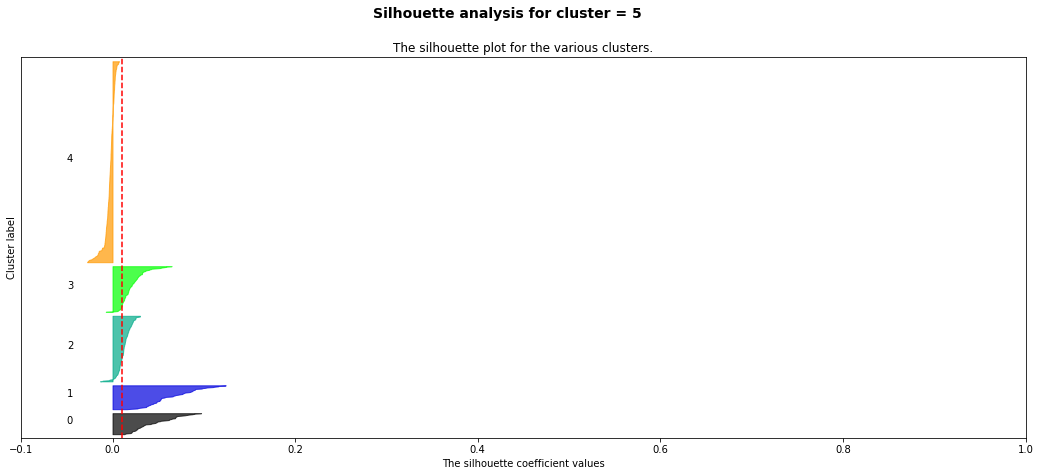

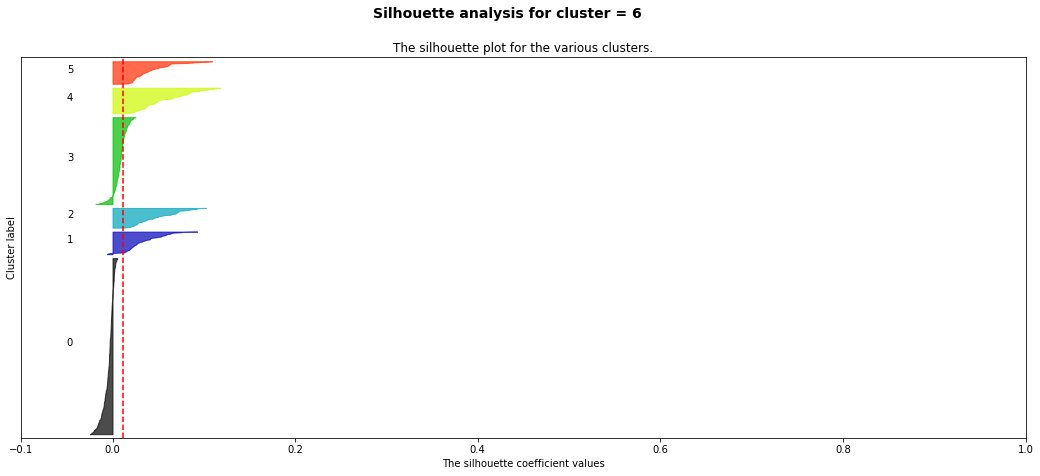

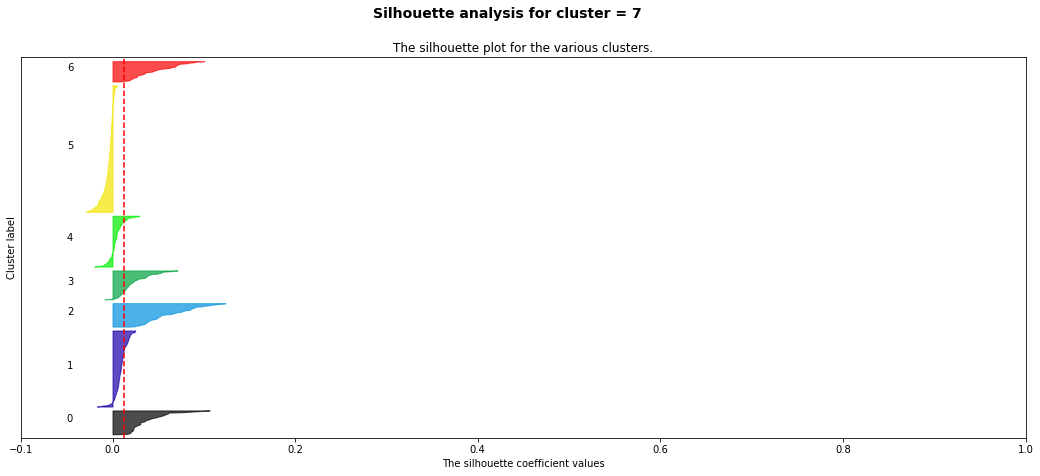

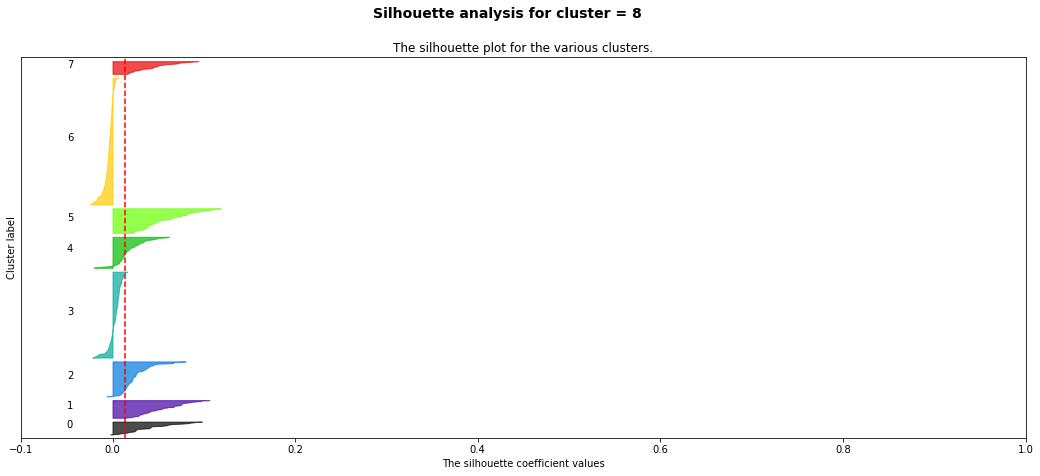

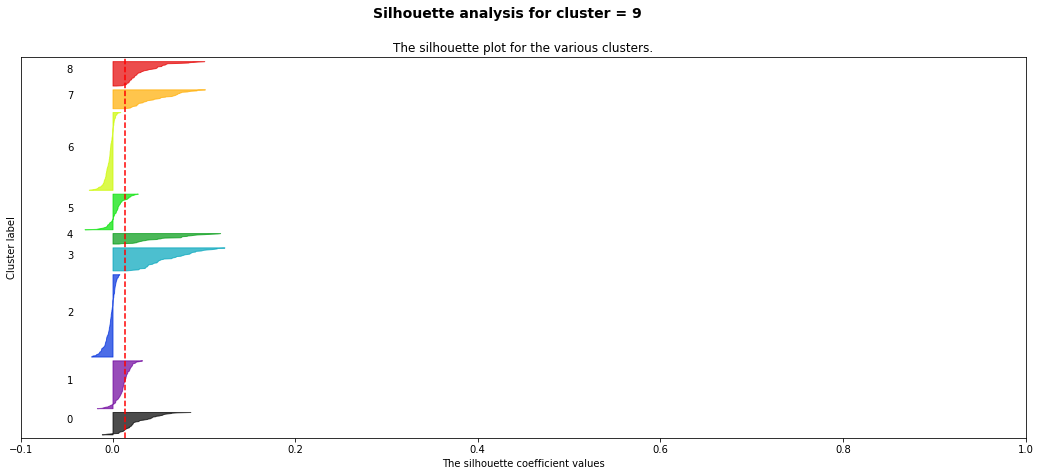

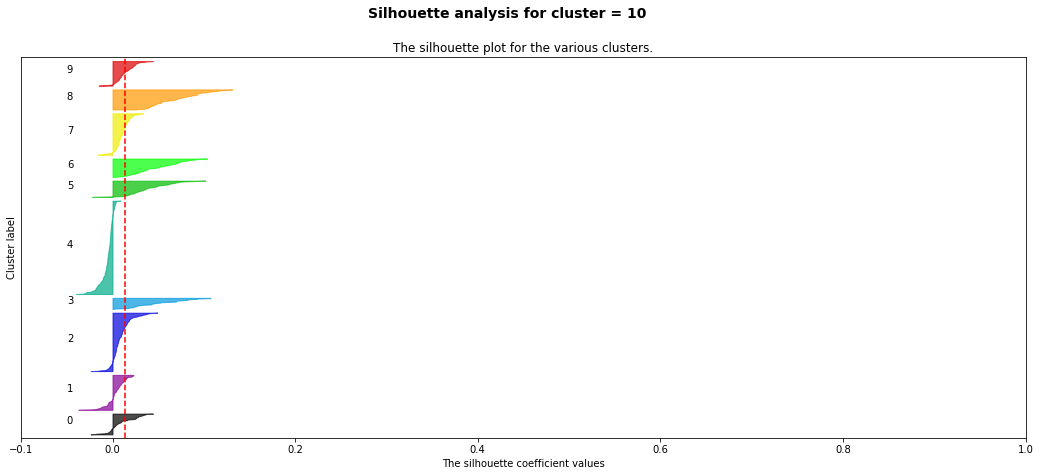

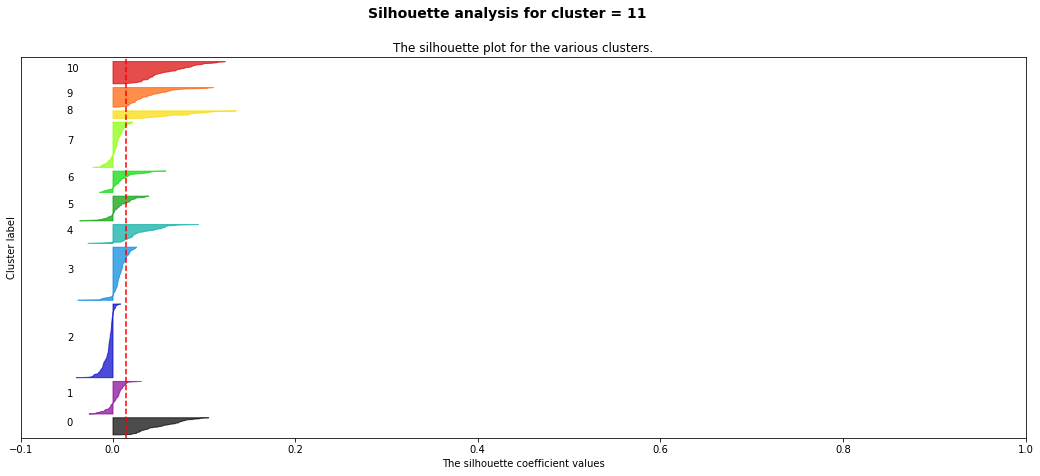

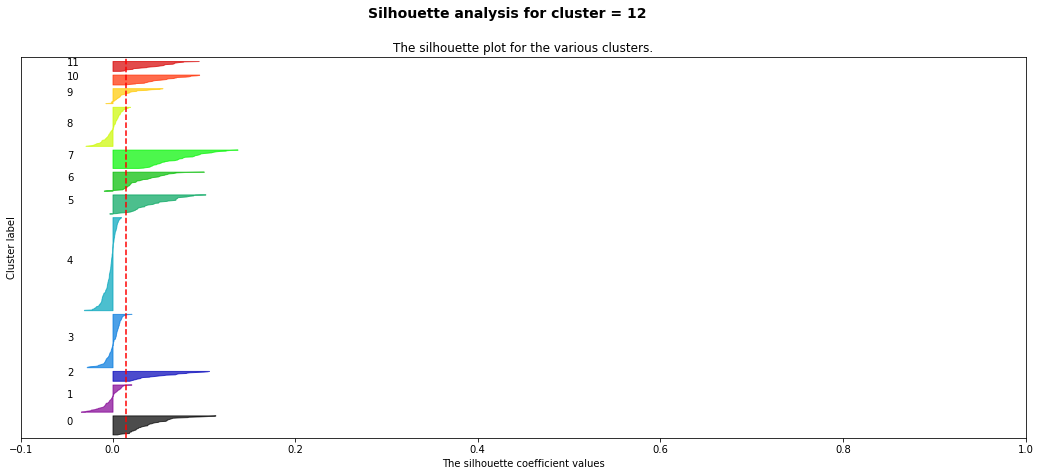

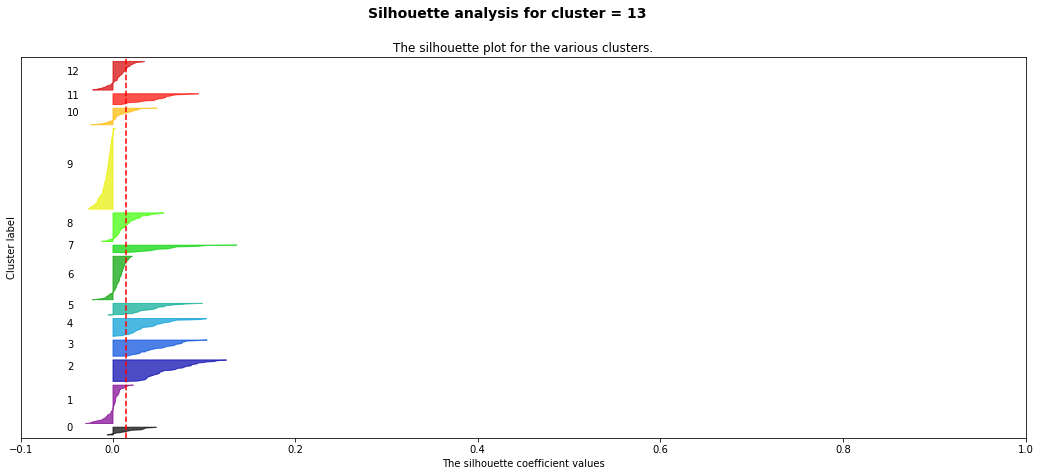

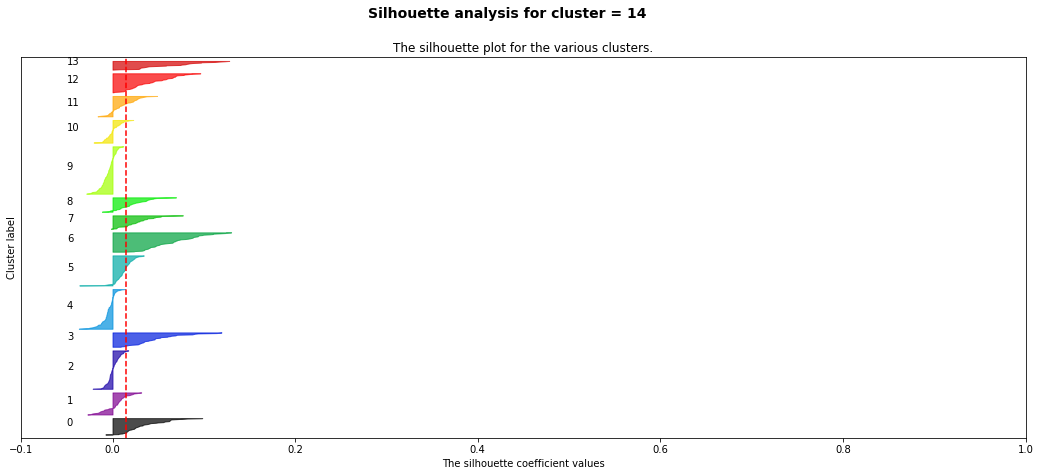

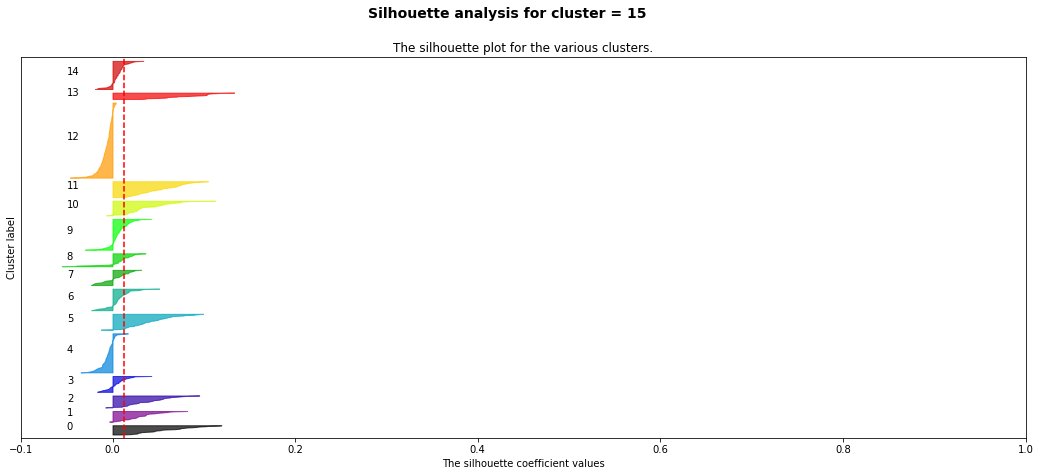

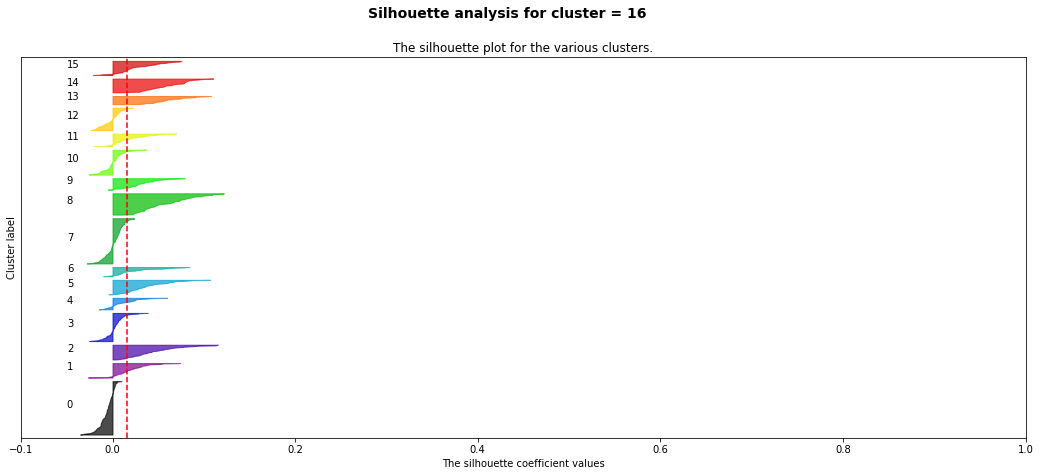

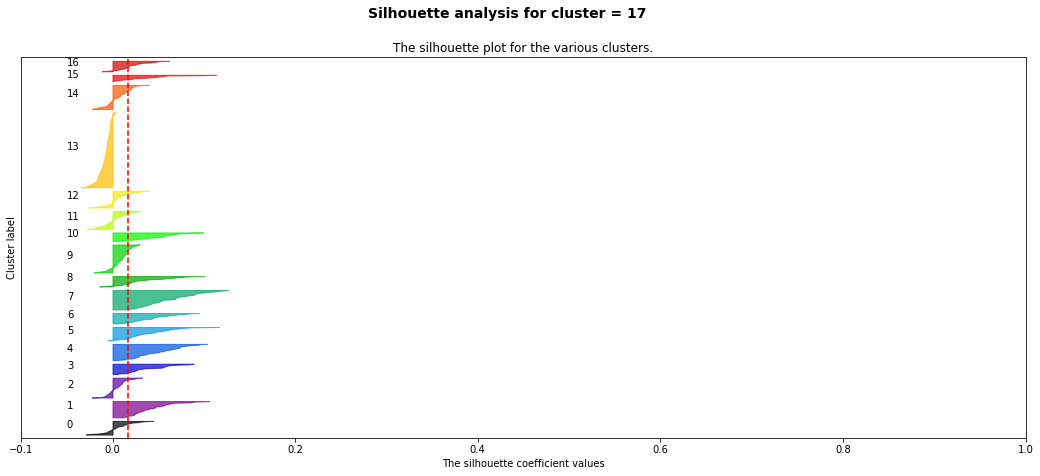

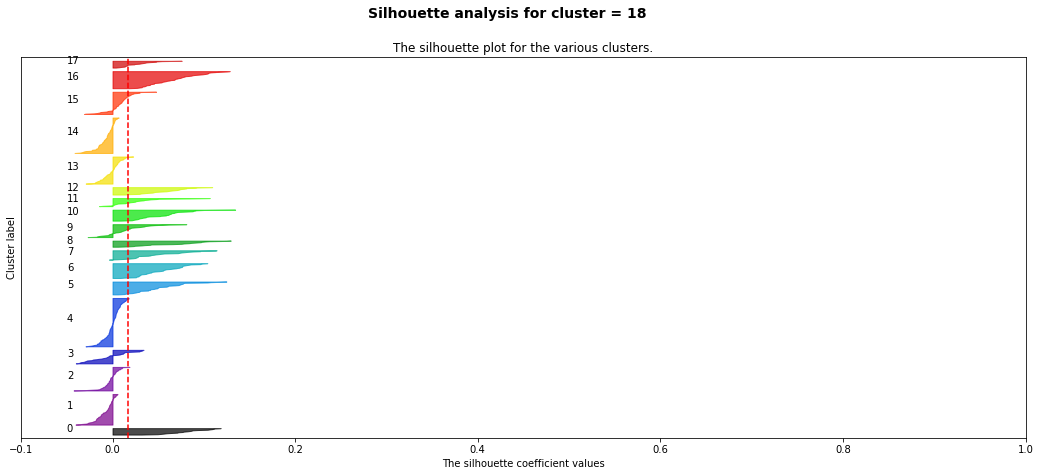

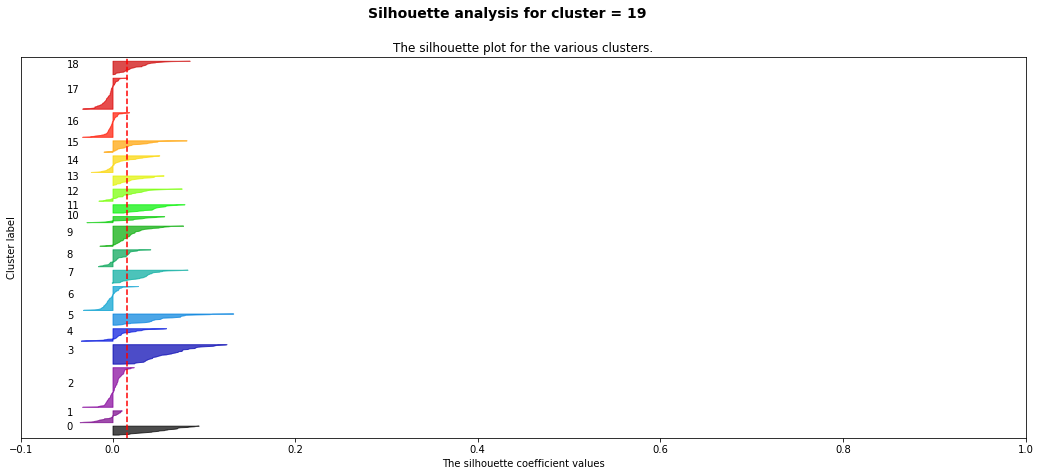

In [36]:
#param
nb_partitions = 4
X = tfidf.toarray()

for n_cluster in range(5,nb_cluster):
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_cluster, max_iter=1000, init='k-means++', n_init=25, n_jobs=-1)
    cluster_labels = clusterer.fit_predict(X)
    

    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    print("For n_cluster =", n_cluster,
          "The average silhouette_score is :", silhouette_avg)
    
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_cluster + 1) * 10])

    y_lower = 10
    for i in range(n_cluster):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for cluster = %d" % n_cluster),
                 fontsize=14, fontweight='bold')
plt.show()

In [14]:
cluster_labels[0]

6

In [37]:
# PARAM decide the number of cluster to keep
n_cluster = 17


# it looks like -> { doc_number : [partition_number, cluster_number] }
doc_clustering = {}
    
clusterer = KMeans(n_clusters=n_cluster, max_iter=1000, init='k-means++')
cluster_labels = clusterer.fit_predict(X)

numDoc = 0
for i in range(0, len(limits)):

    previousBound = 0
    if i > 0:
        previousBound = limits[i-1]
    for numDocItern in range(0, limits[i]-previousBound):
        doc_clustering[numDoc] = [i, clusterer.labels_[numDocItern]]
        numDoc+=1



In [38]:
len(doc_clustering)

991

In [39]:
# Allows to get list of documents number
# return [dou numbers]
# params : partition_number , cluster number
def get_doc(part, clust):
    docs = []
    for i in range(0,len(doc_clustering)):
        if doc_clustering[i][0] == part and doc_clustering[i][1] == clust:
            docs.append(i)
    return docs

In [40]:
# Get the partitions variable
# Here partitions[part][cluster] = list of docs numbe
partitions = []
for i in range(0, len(limits)):
    clusters = []
    for j in range(0, nb_cluster):
        clusters.append(get_doc(i,j))
    partitions.append(clusters)

In [41]:
partitions

[[[48],
  [47, 53, 86],
  [3, 4, 15, 63, 70, 79, 87],
  [1, 9, 13, 39, 45],
  [55, 64, 83, 93, 98],
  [10, 40, 65, 66, 85, 91, 97, 102, 108],
  [0,
   7,
   8,
   14,
   20,
   33,
   35,
   42,
   49,
   58,
   59,
   60,
   67,
   69,
   77,
   81,
   88,
   89,
   94,
   100,
   107,
   113],
  [18, 26, 71, 73, 76, 78, 105],
  [16, 31, 32, 74, 90, 103, 109],
  [24, 27, 30, 44, 82, 110],
  [2, 28, 29, 43, 51, 61, 95, 104, 112],
  [11, 21, 36, 41, 46, 56, 80, 92, 99],
  [5, 25, 52, 57, 68, 101],
  [34, 62, 72, 96],
  [17, 106],
  [12, 19, 22, 37, 38, 54, 75, 84, 111],
  [6, 23, 50],
  [],
  [],
  []],
 [[162, 269, 270, 300],
  [161, 167, 200, 244, 249, 279, 289],
  [117, 118, 129, 177, 184, 193, 201, 250, 257, 282, 288, 290],
  [115, 123, 127, 153, 159, 228, 273, 281, 293],
  [169, 178, 197, 207, 212, 246, 296],
  [124, 154, 179, 180, 199, 205, 211, 216, 222, 277, 286, 294],
  [114,
   121,
   122,
   128,
   134,
   147,
   149,
   156,
   163,
   172,
   173,
   174,
   181,
   183,

# Khi²

In [42]:
# tf_of_your_word = tf[numDoc][strWord]
tf = []
for doc in usable:
    tf_doc = {}
    for word in vectorizer.get_feature_names():
        tf_doc[word] = doc.count(word)
    tf.append(tf_doc)

In [43]:
# Number total of words
# nb_total_word[numPartition]
nb_total_word = []
nb = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        nb += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_total_word.append(nb)
        nb=0
    

In [44]:
nb_total_word

[10917, 17349, 16649, 21289, 28637]

In [45]:
tf[0]

{'acce': 0,
 'accessible': 0,
 'achat': 0,
 'acquisition': 0,
 'acquérir': 0,
 'acteur': 0,
 'actif': 0,
 'action': 0,
 'activite': 0,
 'actuel': 0,
 'actuellement': 0,
 'adapt': 0,
 'adaptatif': 0,
 'adaptation': 0,
 'adapte': 0,
 'adaptee': 0,
 'adapter': 0,
 'adequat': 0,
 'adn': 0,
 'adopter': 0,
 'afc': 0,
 'affiner': 0,
 'agent': 0,
 'agregation': 0,
 'aid': 0,
 'aider': 0,
 'ainsiqu': 0,
 'ajoutee': 0,
 'ajouter': 0,
 'ala': 0,
 'aleatoir': 0,
 'algebriqu': 0,
 'algorithme': 0,
 'algorithme dapprentissage': 0,
 'algorithme dextraction': 0,
 'algorithme efficace': 0,
 'algorithme fouiller': 0,
 'algorithme incremental': 0,
 'algorithmique': 0,
 'alignement': 0,
 'alternatif': 0,
 'amelior': 0,
 'amelioration': 0,
 'ameliore': 0,
 'amelioree': 0,
 'ameliorer': 0,
 'ameliorer qualite': 0,
 'amene': 0,
 'amont': 0,
 'analys': 2,
 'analyse': 2,
 'analyser': 1,
 'analyser factoriel': 0,
 'analyser semantiqu': 0,
 'analytique': 0,
 'anne': 0,
 'annees': 0,
 'annot': 0,
 'annotation': 0

In [46]:
# nb_word[num_partition][word]
nb_word = []

word_in_this_parti = {}
for word in vectorizer.get_feature_names():
    word_in_this_parti[word] = 0

for numDoc in range(0, len(usable)):
    for word in vectorizer.get_feature_names():
        word_in_this_parti[word] += tf[numDoc][word]
    if numDoc+1 in limits:
        nb_word.append(word_in_this_parti)
        word_in_this_parti = {}
        for word in vectorizer.get_feature_names():
            word_in_this_parti[word] = 0

In [47]:
len(nb_word)

5

In [48]:
# nb_word_by_cluster[numPartition][numCluster]
nb_word_by_cluster = []
for parti in partitions:
    nb_word_clus = []
    for cluster in parti:
        nb = 0
        for numDoc in cluster:
            for word in vectorizer.get_feature_names():
                nb += tf[numDoc][word]
        nb_word_clus.append(nb)
    nb_word_by_cluster.append(nb_word_clus)

In [49]:
# value_of_khi2 = khi2[numPartition][numCluster][word]
khi2 = []

for numParti in range(0, len(partitions)):
    khi2parti = []
    for numCluster in range(0, len(partitions[numParti])):
        khi2cluster = {}
        
        for word in vectorizer.get_feature_names():
            if nb_word_by_cluster[numParti][numCluster] == 0:
                khi2cluster[word] = 0
            else:
                word_in_this_parti[word] = 0
                E = nb_word[numParti][word]
                E =+ nb_word_by_cluster[numParti][numCluster]
                E = E/ nb_total_word[numParti]
                N = 0
                for numDoc in partitions[numParti][numCluster]:
                    N += tf[numDoc][word]
                khi2cluster[word] = (pow(N - E, 2)/E)        
        khi2parti.append(khi2cluster)
    khi2.append(khi2parti)

In [50]:
# list of your labels = labels[numPartition][numCluster]
labels = []

for numPartition in range(0, len(nb_word_by_cluster)):
    label_clus = []
    for numCluster in range(0, len(nb_word_by_cluster[numPartition])):
        label_clus.append(Counter(khi2[numPartition][numCluster]).most_common(5))
    labels.append(label_clus)

In [51]:
# Some clusters can be empty
len(labels[0])

20

# Diachronic Analysis

In [57]:
# Low level analysis

#import numpy as np
#import matplotlib.pyplot as plt

#N = 5
#menMeans = (20, 35, 30, 35, 27)
#womenMeans = (25, 32, 34, 20, 25)
#menStd = (2, 3, 4, 1, 2)
#womenStd = (3, 5, 2, 3, 3)
#ind = np.arange(N)    # the x locations for the groups
#width = 0.35       # the width of the bars: can also be len(x) sequence

#p1 = plt.bar(ind, menMeans, width, yerr=menStd)
#p2 = plt.bar(ind, womenMeans, width,
#             bottom=menMeans, yerr=womenStd)

#plt.ylabel('Scores')
#plt.title('Scores by group and gender')
#plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))

#plt.show()

In [53]:

def inter(listA, listB):
    return np.intersect1d(listA, listB)
    
# cluster_t and cluster_s must be in two different partitions
def proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S):
    total_inter = 0
    total_t = 0
    for f in range(0, len(labels[num_partition_T][num_cluster_t])):
        for f_s in labels[num_partition_S][num_cluster_s]:
            if labels[num_partition_T][num_cluster_t][f][0] == f_s[0]:
                total_inter += labels[num_partition_T][num_cluster_t][f][1]
                break
        total_t += labels[num_partition_T][num_cluster_t][f][1]
    if total_t == 0:
        return 0
    return total_inter / total_t
    

def P_A(num_cluster_s, num_partition_T, num_partition_S):
    # first, we have to know what are the cluster which got the label
    total = 0
    nb_computation = 0
    for label_s in labels[num_partition_S][num_cluster_s]:
        for num_cluster_t in range(0, len(partitions[num_partition_T])):
            if label_s in labels[num_partition_T][num_cluster_t]:
                total += proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S)
                nb_computation += 1
    if nb_computation == 0:
        return 0
    return total / nb_computation

# Define a coeficient for the activity 
def activity(num_partition_S, num_partition_T):
    res = 0
    for num_cluster_s in range(0, len(partitions[num_partition_S])):
        res += P_A(num_cluster_s, num_partition_T, num_partition_S)
    return res / len(partitions[num_partition_S])

# Ecart-type, but it isn't very usefull xD
sigma_t = 0.01
sigma_s = 0.01

# Our Graal
def similar(num_cluster_t, num_partition_T, num_cluster_s, num_partition_S):
    cond1 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > P_A(num_cluster_s, num_partition_T, num_partition_S)
    cond2 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > activity(num_partition_S, num_partition_T) + sigma_s
    
    cond3 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > P_A(num_cluster_s, num_partition_T, num_partition_S)
    cond4 = proba(num_cluster_t, num_cluster_s, num_partition_T, num_partition_S) > activity(num_partition_T, num_partition_S) + sigma_t
    return cond1 and cond2 and cond3 and cond4
    

In [54]:
for numParti in range(0, len(partitions)-1):
    for num_cluster_t in range(0, nb_cluster):
        for num_cluster_s in range(0, nb_cluster):
            if similar(num_cluster_t, numParti, num_cluster_s, numParti+1):
                print("("+str(num_cluster_t)+","+str(numParti)+") est similaire à ("+str(num_cluster_s)+","+str(numParti+1)+")")

(2,0) est similaire à (2,1)
(2,0) est similaire à (10,1)
(2,0) est similaire à (13,1)
(2,0) est similaire à (15,1)
(3,0) est similaire à (1,1)
(3,0) est similaire à (5,1)
(3,0) est similaire à (6,1)
(3,0) est similaire à (7,1)
(3,0) est similaire à (8,1)
(3,0) est similaire à (16,1)
(4,0) est similaire à (3,1)
(4,0) est similaire à (6,1)
(4,0) est similaire à (7,1)
(4,0) est similaire à (11,1)
(4,0) est similaire à (12,1)
(4,0) est similaire à (16,1)
(5,0) est similaire à (5,1)
(5,0) est similaire à (6,1)
(5,0) est similaire à (16,1)
(6,0) est similaire à (3,1)
(6,0) est similaire à (4,1)
(6,0) est similaire à (6,1)
(6,0) est similaire à (9,1)
(6,0) est similaire à (11,1)
(6,0) est similaire à (12,1)
(7,0) est similaire à (0,1)
(7,0) est similaire à (12,1)
(7,0) est similaire à (13,1)
(7,0) est similaire à (14,1)
(7,0) est similaire à (16,1)
(8,0) est similaire à (5,1)
(8,0) est similaire à (10,1)
(8,0) est similaire à (12,1)
(8,0) est similaire à (14,1)
(9,0) est similaire à (15,1)
(1

(0,3) est similaire à (2,4)
(0,3) est similaire à (3,4)
(0,3) est similaire à (7,4)
(0,3) est similaire à (11,4)
(0,3) est similaire à (12,4)
(1,3) est similaire à (0,4)
(1,3) est similaire à (4,4)
(1,3) est similaire à (5,4)
(1,3) est similaire à (6,4)
(1,3) est similaire à (10,4)
(1,3) est similaire à (11,4)
(1,3) est similaire à (16,4)
(2,3) est similaire à (0,4)
(2,3) est similaire à (2,4)
(2,3) est similaire à (3,4)
(2,3) est similaire à (4,4)
(2,3) est similaire à (5,4)
(2,3) est similaire à (6,4)
(2,3) est similaire à (7,4)
(2,3) est similaire à (8,4)
(2,3) est similaire à (9,4)
(2,3) est similaire à (10,4)
(2,3) est similaire à (11,4)
(2,3) est similaire à (15,4)
(2,3) est similaire à (16,4)
(3,3) est similaire à (0,4)
(3,3) est similaire à (3,4)
(3,3) est similaire à (5,4)
(3,3) est similaire à (6,4)
(3,3) est similaire à (7,4)
(3,3) est similaire à (8,4)
(3,3) est similaire à (9,4)
(3,3) est similaire à (10,4)
(3,3) est similaire à (11,4)
(3,3) est similaire à (12,4)
(3,3) es

In [55]:
print(labels[0][1])
labels[0][1][0][1]

[('format', 11052.142073146395), ('formation', 11052.142073146395), ('information', 11052.142073146395), ('dinform', 4118.960254964576), ('dinformation', 4118.960254964576)]


11052.142073146395